# RNNs on GPU
After 2 full days of Linux hell I got our Nvidia Tesla K40c to run with keras, and this will speed up computations significantly. Furthermore, I met with Jake Varley who works at Google Brain and knows his shit and he gave me a few tips. I will implement those here, and they are:  

1) one-hot encoding over categorical variables  
2) augment data by "mirroring" it, e.g. double the dataset by switching East and West labels since task is symmetrical  
3) create 2 artificial datasets: one shuffled version where models should not be able to learn anything, and one "hard-coded" one where they should achieve perfect decoding score. This will be a sanity check   
4) give more data to validation and test sets  
5) only include last trial -- this point i'm less sure that I understand. from my understanding including a whole sequence is what gives the memory of the RNN the ability to learn chunks but we'll see. i'm going to try both 'last trial' and a sequence of length n.  
6) switch dropout to 50%  
7) increase batch size to 512  

1-5 are about how we prepare the sequences. The last 2 are about the networks themeselves. 


In [3]:
#BOILERPLATE _______________________
#MODULES ______________________
ROOT = '/Users/pablomartin/python/'
import os
import time
import pickle
import numpy as np
import pandas as pd
import itertools
import operator
import pysftp
import matplotlib.pyplot as plt
from keras.models import load_model

from RNNmodule.SequenceClass import Sequences
from behavioral_performance.utils import fileNames, fileNameLabels
from Visualize.decoding import *
idx = pd.IndexSlice
RANDOM_STATE = 6
print 'modules loaded...'

fileNames.append('PSR_TbyT_Saline_Rigged.p')
fileNames.append('DSR_TbyT_Saline_Shuffled.p')
fileNames.append('PSR_TbyT_Saline_Shuffled.p')
fileNames.append('DSR_TbyT_Naive_Saline.p')
print len(fileNames)
datatype = ['Full', 'Last', 'Med']

modules loaded...
20


## Creating Artificial Datasets
First, let's create a shuffled dataset that no network could learn, so we have a baseline. We will make one for DSR_Saline and PSR_Saline, which are the 2 datasets with most data. We will keep all the trial information the same, but shuffle the labels.  
Also, let's create a 'rigged' dataset that the network should be able to learn to perfection. We're gonna pick an XOR gate, where input A = last choice, input B = reward from penultimate trial. The prediction of this XOR model is highly counterintuitive and there is no chance that that is what rats do. Nonetheless, if we are implementing these models correctly, the network should disregard all the other data, find this pattern, and achieve perfect decoding. Otherwise, we are implementing everything wrong. 

In [3]:
#load saline datasets
DSR_Saline = pickle.load(open(ROOT + 'DATA_structures/TbyT/DSR_TbyT_Saline.p', 'rb'))
PSR_Saline = pickle.load(open(ROOT + 'DATA_structures/TbyT/PSR_TbyT_Saline.p', 'rb'))
#shuffle current choice - these are the eventual labels
np.random.shuffle(DSR_Saline['choice',0].values)
np.random.shuffle(PSR_Saline['choice',0].values)
#save result
pickle.dump(DSR_Saline, open(ROOT + 'DATA_structures/TbyT/DSR_TbyT_Saline_Shuffled.p', 'wb'))
pickle.dump(PSR_Saline, open(ROOT + 'DATA_structures/TbyT/PSR_TbyT_Saline_Shuffled.p', 'wb'))
print 'created shuffled datasets'

#rigged dataset - base will be PSR_Saline
PSR_Saline = pickle.load(open(ROOT + 'DATA_structures/TbyT/PSR_TbyT_Saline.p', 'rb'))
xOR = [a * (not b) + (not a) * b for a,b in zip(PSR_Saline['choice',1],PSR_Saline['reward',2])]
PSR_Saline.loc[:,idx['choice',0]] = xOR
pickle.dump(PSR_Saline, open(ROOT + 'DATA_structures/TbyT/PSR_TbyT_Saline_Rigged.p', 'wb'))
print 'created rigged dataset'

created shuffled datasets
created rigged dataset


## Creating Sequences
Most of the fixes are in the preprocessing stage: preparing sequences. The data augmentation should be done *only* on the training set. 

In [2]:
seq_lengths = [1, 30, 200]
seq_length_labels = ['Last', 'Med', 'Full']
seq_types = ['OneHotBinaryMinimal']

dataset_filenames = [w for w in os.listdir(ROOT + 'DATA_structures/TbyT/') if not w.startswith('.')]
dataset_paths = [ROOT + 'DATA_structures/TbyT/' + w for w in dataset_filenames]

for dataset_file, dataset_path in zip(dataset_filenames, dataset_paths):
    print 'dataset %s' %dataset_file
    df = pickle.load(open(dataset_path, 'rb'))
    for seq_length, seq_type in itertools.product(seq_lengths, seq_types):
        seqObject = Sequences(seq_length, seq_type, RANDOM_STATE = RANDOM_STATE)
        seqObject.create_sequences(df,
                                   timesteps = seq_length,
                                   feature_dim = seq_type,
                                   validate_size = 0.25,
                                   test_size = 0.25)
        seq_length_label =  seq_length_labels[seq_lengths.index(seq_length)]
        pickle.dump(seqObject, open(ROOT + 'DATA_structures/RNN_sequences/' + \
                                            seq_type + '/' + \
                                            seq_length_label + '/' + \
                                            dataset_file, 'wb'))
        print 'finished: %s - %s - %s' %(dataset_file, seq_length, seq_type)
    

dataset PSR_TbyT_Saline.p
finished: PSR_TbyT_Saline.p - 1 - OneHotBinaryMinimal
finished: PSR_TbyT_Saline.p - 30 - OneHotBinaryMinimal
finished: PSR_TbyT_Saline.p - 200 - OneHotBinaryMinimal
dataset PSR_TbyT_FirstTraining.p
finished: PSR_TbyT_FirstTraining.p - 1 - OneHotBinaryMinimal
finished: PSR_TbyT_FirstTraining.p - 30 - OneHotBinaryMinimal
finished: PSR_TbyT_FirstTraining.p - 200 - OneHotBinaryMinimal
dataset DSR_TbyT_Naive_Saline.p
finished: DSR_TbyT_Naive_Saline.p - 1 - OneHotBinaryMinimal
finished: DSR_TbyT_Naive_Saline.p - 30 - OneHotBinaryMinimal
finished: DSR_TbyT_Naive_Saline.p - 200 - OneHotBinaryMinimal
dataset PSR_TbyT_MPFC.p
finished: PSR_TbyT_MPFC.p - 1 - OneHotBinaryMinimal
finished: PSR_TbyT_MPFC.p - 30 - OneHotBinaryMinimal
finished: PSR_TbyT_MPFC.p - 200 - OneHotBinaryMinimal
dataset PSR_TbyT_Saline_Rigged.p
finished: PSR_TbyT_Saline_Rigged.p - 1 - OneHotBinaryMinimal
finished: PSR_TbyT_Saline_Rigged.p - 30 - OneHotBinaryMinimal
finished: PSR_TbyT_Saline_Rigged.p -

## Some Useful Tools
Some tools that would be nice to have are the following:

1) function that finds highest validation accuracy given a folder  
2) plot training vs. validation accuracy and loss
3) 


Let's use pysftp systematically for all this stuff. We're going to take the 10 highest performing models and train them for 1000 epochs. 

In [58]:
def retrieve_val_acc(connection, model_dir):
    if not connection.isdir(model_dir):
        print 'model does not exist... exiting'
        return None
    model_files = connection.listdir(model_dir)
    finished_training = sum([w=='loss_acc_history.p' for w in model_files])
    if finished_training:
        scores = dict([(index, float(w[w.find('-') + 1: -5]))
                       for index, w in enumerate(model_files) if w.startswith('w')])
        best_model = model_files[max(scores, key=scores.get)]
        val_score = max(scores.values())
        return val_score, best_model
    else:
        print 'training did not finish or has not begun...'
        return None
        
        
def retrieve_history(connection, model_dir, path_to_save_to = '.'):
    if not connection.isdir(model_dir):
        print 'model does not exist... exiting'
        return 
    model_files = connection.listdir(model_dir)
    finished_training = sum([w=='loss_acc_history.p' for w in model_files])
    if finished_training:
        connection.get(model_dir + 'loss_acc_history.p', path_to_save_to)
        return 
    else:
        print 'training did not finish or has not begun...'
        return 
    
    
#this will plot standard training/validation progress thru epochs
def plot_training_history(hist, title):
    for field in hist.keys():
        plt.plot(hist[field], label=field)
    plt.xlabel('epochs')
    plt.ylabel('Accuracy / Loss')
    plt.title(title, FontSize = 20)
    plt.legend()
    plt.show()
    


## Retrieve Best Networks
The following code uses a secure file transfer protocol (SFTP) connection into epsilon, finds out which models are done training, and evaluates which are the top ten performing models on the validation set. It saves this information. 

In [52]:
#define parameters to iterate over

epsilon_ROOT = '/home/pablo/python/'

#CREATING NETWORK DIMENSIONS__________
hidden_dimensions = [2, 5, 10, 20, 50, 100]
hidden_dimensions_red = [5, 20, 50]

HDS = np.zeros([69, 3], dtype = int)
HDS[:len(hidden_dimensions), 0] = hidden_dimensions
for index, (hd1, hd2) in enumerate(itertools.product(hidden_dimensions,
                                                     hidden_dimensions)):
    HDS[len(hidden_dimensions) + index, 0] = hd1
    HDS[len(hidden_dimensions) + index, 1] = hd2

counter = np.argmin(np.sum(HDS, axis = 1) != 0)
for index, (hd1, hd2, hd3) in enumerate(itertools.product(hidden_dimensions_red,
                                                          hidden_dimensions_red,
                                                          hidden_dimensions_red)):
    HDS[counter + index, 0] = hd1
    HDS[counter + index, 1] = hd2
    HDS[counter + index, 2] = hd3

cellType_folders = {'RNN' : 'Models/RNN/OneHotBinaryMinimal/',
                    'LSTM' : 'Models/LSTM/Pablo/OneHotBinaryMinimal/'}

rows = pd.MultiIndex.from_product([datatype, [w[:-2] for w in fileNames]],
                                  names =['Seq_Length', 'Dataset'])
cols = pd.MultiIndex.from_product([['val_score', 'cell', 'network', 'full_path'], range(1,11)],
                                  names = ['Network Info', 'Rank'])
MODEL_RESULTS = pd.DataFrame(np.zeros([len(rows), len(cols)]), index=rows, columns=cols)


In [77]:
verbose = 0
connection = pysftp.Connection('10.81.104.156', username='pablo', password='pablo2014')

for fileName, dataPrep in itertools.product(['DSR_TbyT_FirstTraining.p', 'PSR_TbyT_FirstTraining.p',
                                             'DSR_TbyT_MidTraining.p'],
                                            ['Full']):

    d = {}
    print 'working on %s - %s' %(fileName, dataPrep)
    for cell_type, hd in itertools.product(['RNN', 'LSTM'], HDS):
        model_dir = epsilon_ROOT + cellType_folders[cell_type] + dataPrep + '/'
        network_name = '_D_'.join([fileName[:-2]] + [str(w) for w in hd if w > 0])
        model_dir += network_name
        start = time.time()
        tmp_val = retrieve_val_acc(connection, model_dir)
        if verbose: print 'retrieval time: %.3f sec' %(time.time() - start)
        if tmp_val:
            val_score, best_model = tmp_val
            d[best_model] = (val_score, cell_type, network_name)
        
    top_ten = sorted(d, key=lambda x:d[x][0])[-10:]
    for index, key in enumerate(top_ten[::-1]):
        full_path = epsilon_ROOT \
                    + cellType_folders[d[key][1]] \
                    + dataPrep + '/' \
                    + d[key][2] + '/' 
        if verbose: print '%s - exists:%s' %(full_path, connection.isfile(full_path))
        MODEL_RESULTS.loc[idx[dataPrep, fileName[:-2]], idx['val_score', 1 + index]] = d[key][0]
        MODEL_RESULTS.loc[idx[dataPrep, fileName[:-2]], idx['cell', 1 + index]] = d[key][1]
        MODEL_RESULTS.loc[idx[dataPrep, fileName[:-2]], idx['network', 1 + index]] = \
                                                            d[key][2][len(fileName[:-2]) + 1:]
        MODEL_RESULTS.loc[idx[dataPrep, fileName[:-2]], idx['full_path', 1 + index]] = full_path
                                        
                      
MODEL_RESULTS.sort_index(axis = 0, inplace = True)
MODEL_RESULTS.sort_index(axis = 1, inplace = True)
print 'done'

working on DSR_TbyT_FirstTraining.p - Full
working on PSR_TbyT_FirstTraining.p - Full
working on DSR_TbyT_MidTraining.p - Full
training did not finish or has not begun...
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiting
model does not exist... exiti

Network Info                      val_score                        
Rank                                      1     2     3     4     5
Seq_Length Dataset                                                 
Full       DSR_TbyT_FirstTraining      0.84  0.84  0.84  0.84  0.84
           DSR_TbyT_MidTraining        0.84  0.84  0.83  0.83  0.83
           PSR_TbyT_FirstTraining      0.81  0.80  0.80  0.80  0.80


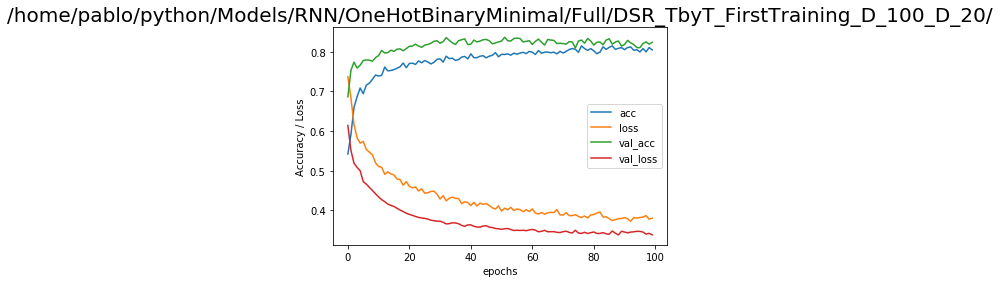

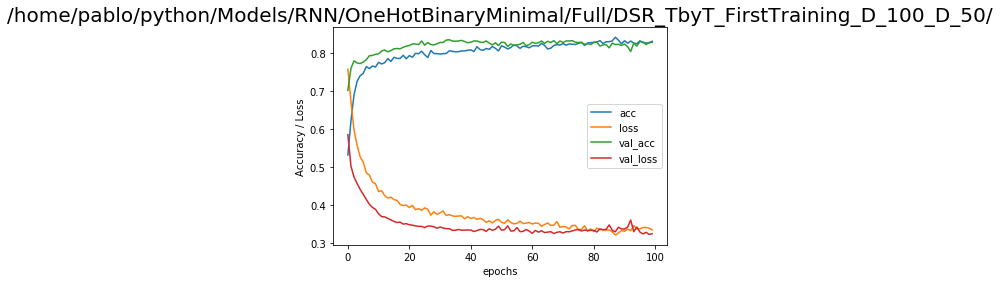

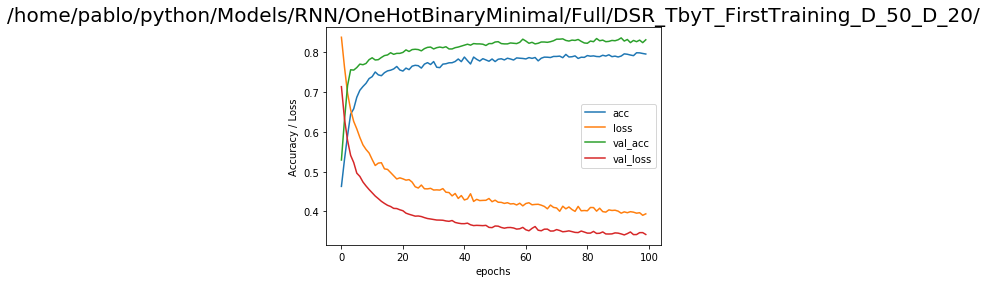

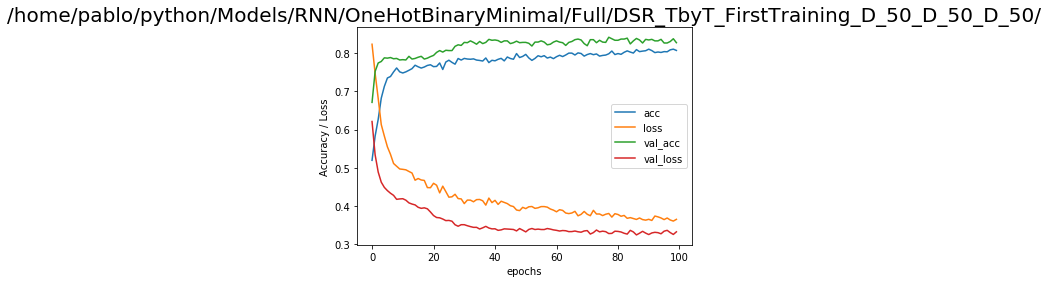

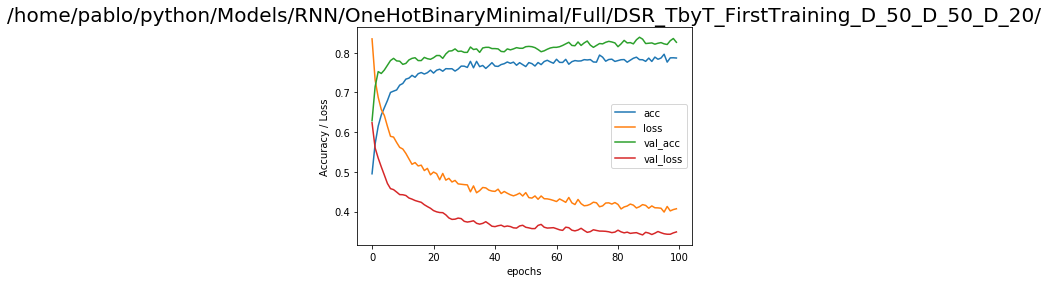

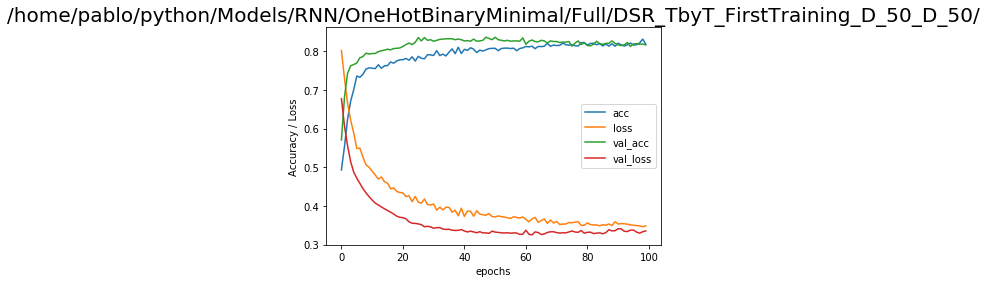

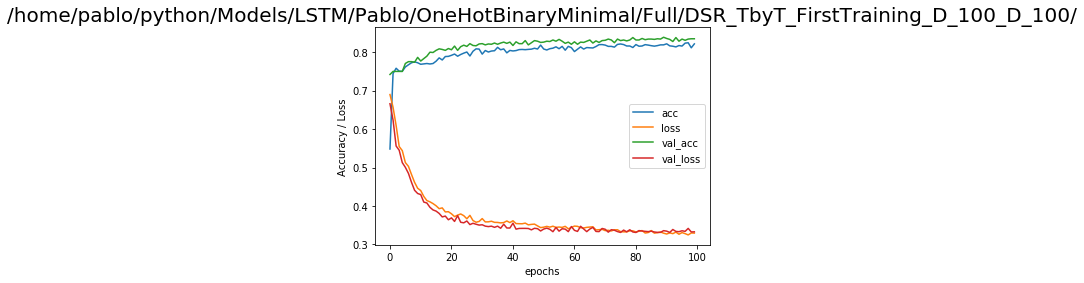

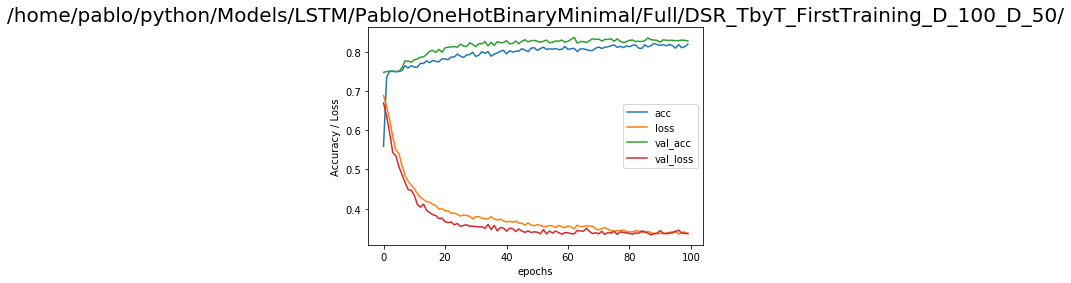

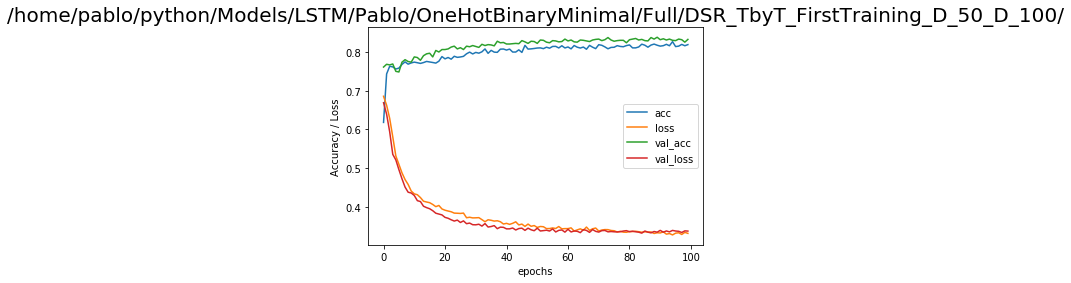

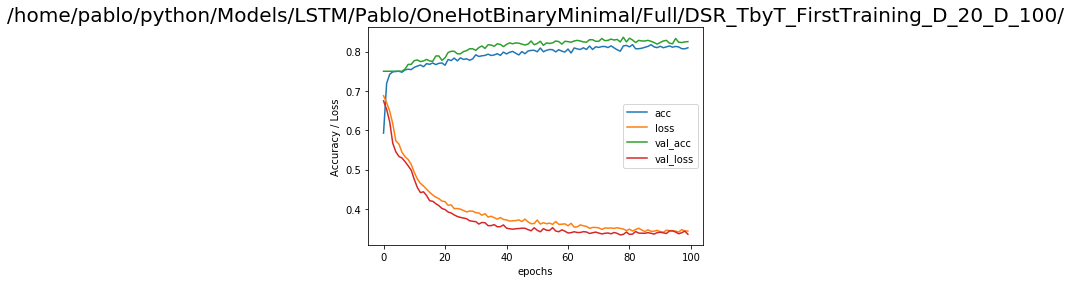

In [78]:
print MODEL_RESULTS.loc[idx['Full',['DSR_TbyT_FirstTraining', 'PSR_TbyT_FirstTraining','DSR_TbyT_MidTraining']],
                        idx['val_score',:5]]

tmp_dir = MODEL_RESULTS.loc[idx['Full',['DSR_TbyT_FirstTraining']],idx['full_path',:]]
for model_dir in tmp_dir.values[0]:
    retrieve_history(connection, model_dir, path_to_save_to = '/Users/pablomartin/python/loss_acc_history.p')
    hist = pickle.load(open('/Users/pablomartin/python/loss_acc_history.p', 'rb'))
    plot_training_history(hist, model_dir)